# **Document Classification Notebook**


> This notebook aims to classify documents into predefined categories using a pre-trained machine learning model. The steps include data preprocessing, transforming text data into vectors, loading a pre-trained model, and predicting the category of the input text data.



In [1]:
pip install pdfminer python-docx comtypes -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.4/229.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.4 MB/s eta 0:00:00


## **Import essential libraries for data processing and NLP.**



> This cell imports several libraries: pandas for data manipulation, re for regular expressions, string for string operations, and NLTK modules (stopwords and WordNetLemmatizer) for natural language processing.



In [2]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [3]:
from subprocess import Popen, PIPE
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
import io
from io import StringIO
import os
import glob
import docx
#import comtypes.client
import sys
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')



> *This cell defines a function read_text_files that reads all text files from a specified folder, assigns a category to each, and returns a DataFrame with the text data and corresponding categories.*



In [4]:
def read_text_files(folder_path, category):
    # Initialize a list to hold the data
    data = []

    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                file_contents = file.read()
                data.append({'Text_Data': file_contents, 'Category': category})

    # Create a DataFrame
    df = pd.DataFrame(data)
    return df

## **Load and categorize text data from different folders.**



> This cell uses the read_text_files function to read text files from different folders (business, sports, politics, tech, entertainment) and stores the categorized data in separate DataFrames.



In [5]:
df_business = read_text_files('/content/drive/MyDrive/document_classification/business', 'business')
df_entertainment = read_text_files('/content/drive/MyDrive/document_classification/entertainment', 'entertainment')
df_politics = read_text_files('/content/drive/MyDrive/document_classification/politics', 'politics')
df_sport = read_text_files('/content/drive/MyDrive/document_classification/sport', 'sport')
df_tech = read_text_files('/content/drive/MyDrive/document_classification/technologie', 'tech')
df_medical = read_text_files('/content/drive/MyDrive/document_classification/medical', 'medical')


In [6]:
df_business.head()

,Text_Data,Category
0,Crossrail link 'to get go-ahead'\n\nThe £10bn ...,business
1,India's rupee hits five-year high\n\nIndia's r...,business
2,Winn-Dixie files for bankruptcy\n\nUS supermar...,business
3,Deutsche Boerse boosts dividend\n\nDeutsche Bo...,business
4,Lufthansa flies back to profit\n\nGerman airli...,business


In [7]:
# Make sure you have downloaded the stopwords and wordnet data
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text_column(df, column_name):
    stop = set(stopwords.words('english'))
    stop.update(['shall', 'said', 'u', 'would', 'mr', 'say', 'bn','also'])
    stemmer = WordNetLemmatizer()
    # Lower case conversion
    df[column_name] = df[column_name].apply(lambda x: " ".join(x.lower() for x in x.split()))
    # Remove special characters
    df[column_name] = df[column_name].str.replace('[^\w\s]', '', regex=True)
    # Remove numeric values
    df[column_name] = df[column_name].str.replace('\d+', '', regex=True)
    # Remove stop words
    df[column_name] = df[column_name].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    # Lemmatize words
    df[column_name] = df[column_name].apply(lambda x: " ".join(stemmer.lemmatize(word) for word in x.split()))
    # Remove specific word 'shall'
    df[column_name] = df[column_name].str.replace('shall', '', regex=True)

    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [8]:
df_business = preprocess_text_column(df_business, 'Text_Data')
df_entertainment = preprocess_text_column(df_entertainment, 'Text_Data')
df_politics = preprocess_text_column(df_politics, 'Text_Data')
df_sport = preprocess_text_column(df_sport, 'Text_Data')
df_tech = preprocess_text_column(df_tech, 'Text_Data')
df_medical = preprocess_text_column(df_medical, 'Text_Data')

In [9]:
df_business

,Text_Data,Category
0,crossrail link get goahead crossrail transport...,business
1,india rupee hit fiveyear high india rupee hit ...,business
2,winndixie file bankruptcy u supermarket group ...,business
3,deutsche boerse boost dividend deutsche boerse...,business
4,lufthansa fly back profit german airline lufth...,business
...,...,...
95,u industrial output growth eas u industrial pr...,business
96,karachi stock hit historic high karachi stock ...,business
97,german economy rebound germany economy biggest...,business
98,mixed christmas u retailer u retailer posted m...,business


In [10]:
def add_identifiers_column(df, text_column='Text_Data', num_identifiers=5):
    """
    Add a column of top N most frequent words (identifiers) to the DataFrame after removing stop words.

    :param df: Input DataFrame
    :param text_column: Column name containing text data
    :param num_identifiers: Number of top frequent words to identify
    :return: DataFrame with an added 'Identifiers' column
    """
    # Process the text data
    text_data = ' '.join(df[text_column]).split()

    # Define the stop words
    stop_words = set(stopwords.words('english'))
    stop_words.update(['shall', 'said', 'u', 'would', 'mr', 'say', 'bn','also', 'year', 'one'])

    # Filter out stop words
    filtered_words = [word for word in text_data if word.lower() not in stop_words]

    # Get the top N most frequent words
    identifier = pd.Series(filtered_words).value_counts().index[:num_identifiers]

    # Converting the index to a list
    identifier_list = list(identifier)

    # Add the identifier_list as a new column to the DataFrame
    df['Identifiers'] = [identifier_list] * len(df)

    return df

In [11]:
df_business = add_identifiers_column(df_business)
df_entertainment = add_identifiers_column(df_entertainment)
df_politics = add_identifiers_column(df_politics)
df_sport = add_identifiers_column(df_sport)
df_tech = add_identifiers_column(df_tech)
df_medical = add_identifiers_column(df_medical)

In [12]:
df_entertainment.head()

,Text_Data,Category,Identifiers
0,campaigner attack mtv sleaze mtv criticised in...,entertainment,"[film, show, award, best, music]"
1,hillbilly singer scoggins dy country western m...,entertainment,"[film, show, award, best, music]"
2,housewife lift channel rating debut u televisi...,entertainment,"[film, show, award, best, music]"
3,sundance honour foreign film international fil...,entertainment,"[film, show, award, best, music]"
4,eastenders set u remake plan create u soap bas...,entertainment,"[film, show, award, best, music]"


In [13]:
frames = [df_business, df_entertainment, df_medical, df_politics, df_sport, df_tech]
finalframe = pd.concat(frames,sort=False)
finalframe = finalframe[['Identifiers','Text_Data','Category']]
finalframe = finalframe.reset_index(drop=True)
finalframe[:5]

,Identifiers,Text_Data,Category
0,"[sale, market, growth, price, economy]",crossrail link get goahead crossrail transport...,business
1,"[sale, market, growth, price, economy]",india rupee hit fiveyear high india rupee hit ...,business
2,"[sale, market, growth, price, economy]",winndixie file bankruptcy u supermarket group ...,business
3,"[sale, market, growth, price, economy]",deutsche boerse boost dividend deutsche boerse...,business
4,"[sale, market, growth, price, economy]",lufthansa fly back profit german airline lufth...,business


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
# Generating 1000 features for the input for the model
tfidfconverter = TfidfVectorizer(max_features=1000, stop_words=stopwords.words('english'))
X = pd.DataFrame(tfidfconverter.fit_transform(finalframe['Text_Data']).toarray())
print(X[:5])
#X.columns = range(X.shape[1])
labelencoder = LabelEncoder() #Converting the labels to numeric labels
y = labelencoder.fit_transform(finalframe['Category'])

   0    1    2         3    4    5    6    7         8    9    ...       990  \
0  0.0  0.0  0.0  0.076117  0.0  0.0  0.0  0.0  0.000000  0.0  ...  0.000000   
1  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  ...  0.000000   
2  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.099129  0.0  ...  0.000000   
3  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  ...  0.082417   
4  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  ...  0.000000   

       991  992  993  994       995  996       997  998  999  
0  0.00000  0.0  0.0  0.0  0.038623  0.0  0.000000  0.0  0.0  
1  0.00000  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  
2  0.00000  0.0  0.0  0.0  0.000000  0.0  0.100158  0.0  0.0  
3  0.04889  0.0  0.0  0.0  0.070832  0.0  0.000000  0.0  0.0  
4  0.00000  0.0  0.0  0.0  0.047915  0.0  0.000000  0.0  0.0  

[5 rows x 1000 columns]


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [16]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [17]:
import numpy as np
unique, counts = np.unique(y_resampled, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 100]
 [  1 100]
 [  2 100]
 [  3 100]
 [  4 100]
 [  5 100]]


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
classifier = RandomForestClassifier(n_estimators=1200, random_state=1)  #defining 1000 nodes
rf = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

Accuracy: 0.9888888888888889
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        31
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        30
           3       0.97      1.00      0.98        31
           4       1.00      1.00      1.00        34
           5       0.97      1.00      0.98        30

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180

Confusion matrix:
 [[29  0  0  1  0  1]
 [ 0 24  0  0  0  0]
 [ 0  0 30  0  0  0]
 [ 0  0  0 31  0  0]
 [ 0  0  0  0 34  0]
 [ 0  0  0  0  0 30]]


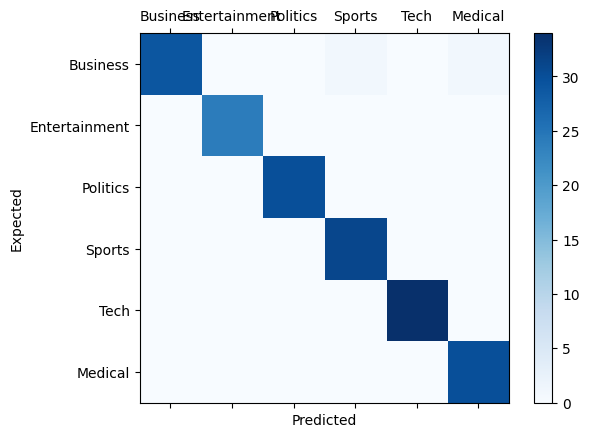

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('Accuracy: %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))
#print(confusion_matrix(y_test,y_pred))

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Business','Entertainment','Politics','Sports','Tech', 'Medical']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [22]:
import pickle
import requests
import json
pickle.dump(rf, open('rfmodel.pkl','wb'))

In [21]:
import joblib

# Assuming you have your TfidfVectorizer named tfidfconverter
joblib.dump(tfidfconverter, 'rfTfidf.pkl')


['rfTfidf.pkl']

Accuracy: 0.9444444444444444
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        31
           1       1.00      0.92      0.96        24
           2       0.97      1.00      0.98        30
           3       0.86      0.97      0.91        31
           4       0.97      1.00      0.99        34
           5       0.96      0.87      0.91        30

    accuracy                           0.94       180
   macro avg       0.95      0.94      0.94       180
weighted avg       0.95      0.94      0.94       180

Confusion matrix:
 [[28  0  0  2  0  1]
 [ 0 22  1  0  1  0]
 [ 0  0 30  0  0  0]
 [ 1  0  0 30  0  0]
 [ 0  0  0  0 34  0]
 [ 1  0  0  3  0 26]]


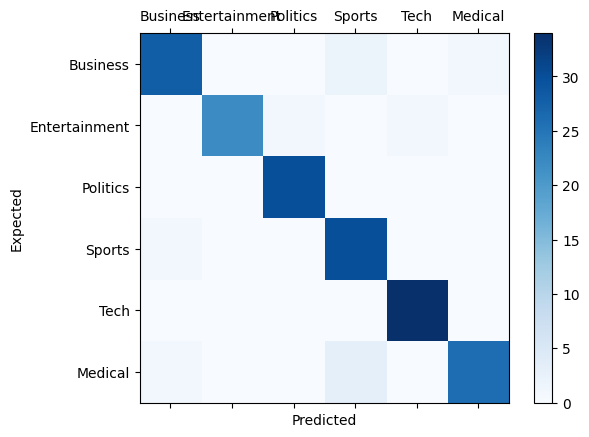

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %s" % (accuracy))
print(classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Business','Entertainment','Politics','Sports','Tech', 'Medical']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [23]:
pickle.dump(xgb, open('xgbmodel.pkl','wb'))

Accuracy: 0.9888888888888889
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        30
           3       0.94      1.00      0.97        31
           4       1.00      1.00      1.00        34
           5       1.00      0.97      0.98        30

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180

Confusion matrix:
 [[30  0  0  1  0  0]
 [ 0 24  0  0  0  0]
 [ 0  0 30  0  0  0]
 [ 0  0  0 31  0  0]
 [ 0  0  0  0 34  0]
 [ 0  0  0  1  0 29]]


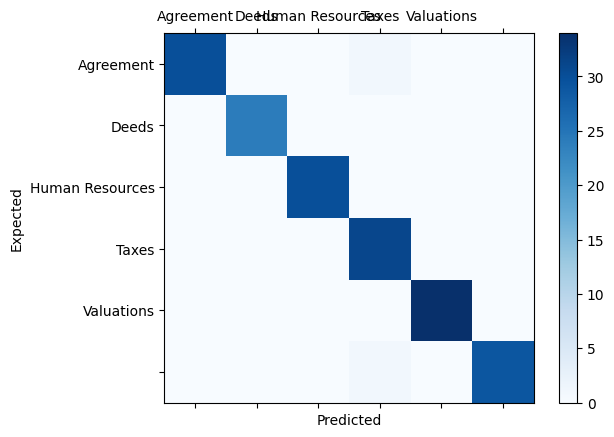

In [24]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Accuracy: %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Agreement', 'Deeds','Human Resources','Taxes','Valuations']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [25]:
pickle.dump(clf, open('nbmodel.pkl','wb'))

In [26]:
import pandas as pd
import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

def process_and_predict(text_file_path, model_path, vectorizer_path):
    # Load the text file and read its content
    with open(text_file_path, 'r') as file:
        textdata = file.readlines()

    # Creating a DataFrame
    dfdemo = pd.DataFrame(textdata, columns=['Data'])

    stop = set(stopwords.words('english'))


    # Convert to lower case
    dfdemo['Data'] = dfdemo['Data'].apply(lambda x: " ".join(x.lower() for x in x.split()))

    # Remove special characters
    dfdemo['Data'] = dfdemo['Data'].str.replace('[^\w\s]', '', regex=True)

    # Remove numeric values from between the words
    dfdemo['Data'] = dfdemo['Data'].str.replace('\d+', '', regex=True)

    # Remove numerical numbers
    dfdemo['Data'] = dfdemo['Data'].apply(lambda x: x.translate(str.maketrans('', '', string.digits)))

    # Remove stop words
    stop = set(stopwords.words('english'))
    dfdemo['Data'] = dfdemo['Data'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

    # Lemmatization
    stemmer = WordNetLemmatizer()
    dfdemo['Data'] = dfdemo['Data'].apply(lambda x: " ".join(stemmer.lemmatize(word) for word in x.split()))

    # Transforming text data into vectors using TF-IDF
    tfidfconverter = joblib.load(vectorizer_path)
    inputs = pd.DataFrame(tfidfconverter.fit_transform(dfdemo['Data']).toarray())

    # Load the pre-trained model
    savedmodel = pickle.load(open(model_path, 'rb'))

    # Predicting the category of the input text data
    output_category = savedmodel.predict(inputs)

    # If necessary, inverse transform the predicted labels
    try:
        labelencoder = savedmodel.named_steps['labelencoder']
        output_category = labelencoder.inverse_transform(output_category)
    except:
        pass  # This step is skipped if there's no labelencoder

    return output_category